# 병렬 노드 실행을 위한 분기 생성 방법

![](image/langgraph-09.jpeg)

노드의 병렬 실행은 전체 그래프 작업의 속도를 향상시키는 데 필수적입니다. `LangGraph`는 노드의 병렬 실행을 기본적으로 지원하며, 이는 그래프 기반 워크플로우의 성능을 크게 향상시킬 수 있습니다. 

이러한 병렬화는 **fan-out**과 **fan-in** 메커니즘을 통해 구현되며, 표준 엣지와 `conditional_edges` 를 활용합니다. 

## 환경 설정

In [17]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## 병렬 노드 fan-out 및 fan-in

**fan-out / fan-in**

병렬 처리에서 **fan-out**과 **fan-in**은 작업을 나누고 모으는 과정을 설명하는 개념입니다.

- **Fan-out (확장)**: 큰 작업을 여러 작은 작업으로 쪼갭니다. 예를 들어, 피자를 만들 때 도우, 소스, 치즈 준비를 각각 별도로 할 수 있습니다. 이렇게 각각의 파트를 나눠 동시에 처리하는 것이 fan-out입니다.

- **Fan-in (수집)**: 나뉜 작은 작업들을 다시 하나로 합칩니다. 피자에 준비된 재료들을 모두 올려 완성 피자를 만드는 과정처럼, 여러 작업이 끝나면 결과를 모아 최종 작업을 완성하는 것이 fan-in입니다.

즉, **fan-out**으로 작업을 분산시키고, **fan-in**으로 결과를 합쳐 최종 결과를 얻는 흐름입니다.

----

이 예시에서는 `Node A`에서 `B and C`로 팬아웃하고 `D`로 팬인하는 과정을 보여줍니다. 

State에서는 `reducer(add)` 연산자를 지정합니다. 이는 State 내 특정 키의 기존 값을 단순히 덮어쓰는 대신 값들을 결합하거나 누적합니다. 리스트의 경우, 새로운 리스트를 기존 리스트와 연결하는 것을 의미합니다.

LangGraph는 State의 특정 키에 대한 reducer 함수를 지정하기 위해 `Annotated` 타입을 사용합니다. 이는 타입 검사를 위해 원래 타입(`list`)을 유지하면서도, 타입 자체를 변경하지 않고 reducer 함수(`add`)를 타입에 첨부할 수 있게 합니다.

In [2]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

그래프를 시각화 합니다.

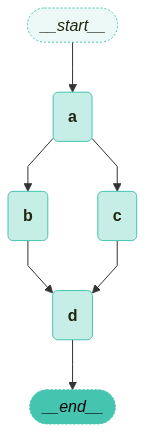

In [3]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

`reducer`를 통해 각 노드에 추가된 값들이 **누적**되는 것을 확인할 수 있습니다.

In [4]:
# 그래프 실행
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='c7f9f5af-f3c1-440e-a7c0-704247ca9602')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='c7f9f5af-f3c1-440e-a7c0-704247ca9602')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='c7f9f5af-f3c1-440e-a7c0-704247ca9602'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='652003ae-9056-4913-8a71-26412d67943e'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='a4ce48d4-7bec-43a1-b6ab-48e2418485e1')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='c7f9f5af-f3c1-440e-a7c0-704247ca9602'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='652003ae-9056-4913-8a71-26412d67943e'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='a4ce48d4-7bec-43a1-b6ab-48e2418485e1'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='a537a11c-19b6-48e3-8c5c-0ab4db0b50a3')]}

### 병렬처리 중 예외 발생시 대응

LangGraph는 "superstep(여러 노드들이 처리되는 전체 프로세스 스텝)" 내에서 노드를 실행하는데, 이는 병렬 분기가 동시에 실행되더라도 전체 superstep이 **트랜잭션** 방식으로 처리됨을 의미합니다. 

따라서, 이러한 분기 중 하나라도 예외가 발생하면, 상태에 대한 업데이트가 **전혀** 적용되지 않습니다(전체 superstep이 오류 처리됨).

> superstep: 여러 노드들이 처리되는 전체 프로세스 스텝

![](image/langgraph-09.jpeg)


오류가 발생하기 쉬운 작업(예: 불안정한 API 호출 처리)이 있는 경우, LangGraph는 이를 해결하기 위한 두 가지 방법을 제공합니다.

1. 노드 내에서 일반적인 Python 코드를 작성하여 예외를 포착하고 처리할 수 있습니다.
2. **[retry_policy](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy)** 를 설정하여 특정 유형의 예외가 발생한 노드를 재시도하도록 그래프를 지시할 수 있습니다. 실패한 분기만 재시도되므로 불필요한 작업 수행에 대해 걱정할 필요가 없습니다.

이러한 기능들을 통해 병렬 실행과 예외 처리를 완벽하게 제어할 수 있습니다.

## 추가 단계가 있는 병렬 노드의 fan-out 및 fan-in

위의 예시에서는 각 경로가 단일 단계일 때의 `fan-out`과 `fan-in` 방법을 보여주었습니다. 하지만 하나의 경로에 여러 단계가 있다면 어떻게 될까요?

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 생성 및 연결
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

그래프를 시각화합니다.

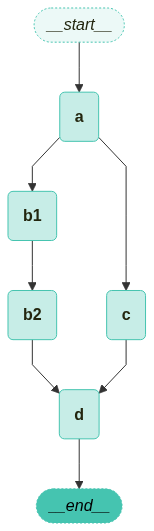

In [6]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [7]:
# 빈 리스트를 사용한 그래프 집계 연산 실행, 모든 데이터에 대한 기본 집계 수행
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6905af71-e71c-40f7-9823-607144ac7b78')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6905af71-e71c-40f7-9823-607144ac7b78')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6905af71-e71c-40f7-9823-607144ac7b78'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='5160e68b-437f-461d-9f92-7b03d2c7acbe'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='0c68e7a7-def4-474f-ac52-64c8e622347e')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6905af71-e71c-40f7-9823-607144ac7b78'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='5160e68b-437f-461d-9f92-7b03d2c7acbe'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='0c68e

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='6905af71-e71c-40f7-9823-607144ac7b78'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='5160e68b-437f-461d-9f92-7b03d2c7acbe'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='0c68e7a7-def4-474f-ac52-64c8e622347e'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='4ef2f8b1-55e8-4ef2-bbd8-89865aa937c9'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='5bfbaac5-7a61-4306-9803-703406df1752')]}

## 조건부 분기(conditional branching)

fan-out이 결정적이지 않은 경우, `add_conditional_edges` 를 직접 사용할 수 있습니다.

조건부 분기 이후 연결될 알려진 "sink" 노드가 있는 경우, 조건부 엣지를 생성할 때 `then="실행할 노드명"` 을 제공할 수 있습니다.

In [8]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 전체 병렬 처리할 노드 목록
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


# 최종 노드 연결 및 그래프 컴파일
builder.add_edge("e", END)
graph = builder.compile()

아래는 참고용 코드입니다. `then` 문법을 사용할 경우, `then="e"` 를 추가하고 edge 연결을 추가하지 않아도 됩니다.

In [9]:
## then 문법 사용시
# builder.add_conditional_edges(
#     "a",
#     route_bc_or_cd,
#     intermediates,
#     then="e",
# )

그래프를 시각화합니다.

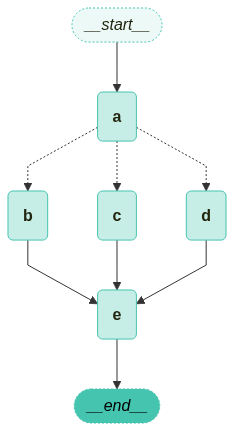

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [11]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='37a5102b-55a0-41d7-89f6-55a1bd100c34')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='37a5102b-55a0-41d7-89f6-55a1bd100c34')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='37a5102b-55a0-41d7-89f6-55a1bd100c34'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='6a9be97f-e0cc-4792-8731-6e1dc8c9f5c5'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2b6396ef-1ce7-4001-b5cb-07b214eec333')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='37a5102b-55a0-41d7-89f6-55a1bd100c34'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='6a9be97f-e0cc-4792-8731-6e1dc8c9f5c5'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2b6396ef-1ce7-4001-b5cb-07b214eec333'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='4189308e-f2eb-46a7-b7af-083a7b927ee9')],
 'which': 'bc'}

In [12]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ac45a128-7722-4d12-a429-2968f5a3e235')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ac45a128-7722-4d12-a429-2968f5a3e235')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ac45a128-7722-4d12-a429-2968f5a3e235'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='b8e4fa05-8cca-4814-bdf8-c082e9de3c96'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='6f22961c-3050-471b-ba21-5d5d2b13b5a1')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ac45a128-7722-4d12-a429-2968f5a3e235'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='b8e4fa05-8cca-4814-bdf8-c082e9de3c96'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='6f22961c-3050-471b-ba21-5d5d2b13b5a1'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='713ef7ee-92ff-41f9-9083-b2fa28a9f456')],
 'which': 'cd'}

## fan-out 값의 신뢰도에 따른 정렬

병렬로 펼쳐진 노드들은 하나의 "**super-step**"으로 실행됩니다. 각 super-step 에서 발생한 업데이트들은 해당 super-step 이 완료된 후 순차적으로 상태에 적용됩니다.

병렬 super-step 에서 일관된 사전 정의된 업데이트 순서가 필요한 경우, 출력값을 식별 키와 함께 상태의 별도 필드에 기록한 다음, 팬아웃된 각 노드에서 집결 지점까지 일반 `edge` 를 추가하여 "sink" 노드에서 이들을 결합해야 합니다.

예를 들어, 병렬 단계의 출력을 "신뢰도"에 따라 정렬하고자 하는 경우를 고려해보겠습니다.

In [13]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 팬아웃 값들의 병합 로직 구현, 빈 리스트 처리 및 리스트 연결 수행
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # 덮어쓰기
        return []
    return left + right


# 상태 관리를 위한 타입 정의, 집계 및 팬아웃 값 저장 구조 설정
class State(TypedDict):
    # add_messages 리듀서 사용
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# 병렬 노드 값 반환 클래스
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# 신뢰도(reliability)가 다른 병렬 노드들 추가
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# 팬아웃 값들을 신뢰도 기준으로 정렬하고 최종 집계 수행
def aggregate_fanout_values(state: State) -> Any:
    # 신뢰도 기준 정렬
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# 집계 노드 추가
builder.add_node("e", aggregate_fanout_values)


# 상태에 따른 조건부 라우팅 로직 구현
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 중간 노드들 설정 및 조건부 엣지 추가
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# 중간 노드들과 최종 집계 노드 연결
for node in intermediates:
    builder.add_edge(node, "e")

# 그래프 완성을 위한 최종
graph = builder.compile()

그래프를 시각화합니다.

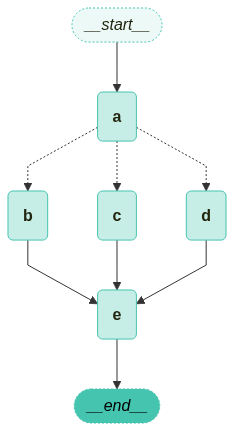

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

병렬로 노드 실행시 결과를 reliability 기준으로 정렬합니다.

**참고**

- `b`: reliability=0.1
- `c`: reliability=0.9
- `d`: reliability=0.5

In [15]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='95364e46-e905-47a2-8573-d6c05fddf697')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='95364e46-e905-47a2-8573-d6c05fddf697')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='95364e46-e905-47a2-8573-d6c05fddf697'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='5a808748-4363-435d-b8f4-bbc7102f7178'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f2170238-9e25-467c-9db2-ff7e836e6764'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='2117061b-54d9-4f83-896c-013d488dbbef')],
 'fanout_values': [],
 'which': 'bc'}

In [16]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='08608410-0d8e-46b0-abfc-d547d274d9ee')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='08608410-0d8e-46b0-abfc-d547d274d9ee')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='08608410-0d8e-46b0-abfc-d547d274d9ee'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2e3a1157-3222-4236-b6db-6a3c2f89d636'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='6a6a9e93-c249-47ac-bb7d-92be214c75d0'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='a6a2b728-1358-4d1e-b1da-5aa7d53d4f18')],
 'fanout_values': [],
 'which': 'cd'}